In [2]:
import torch
import torch.nn as nn  
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [3]:
#The images need to be preprocessed before being fed into the network
#transform essential composes several transformations together
#ToTensor() converts the images into a pytorch tensor
#Normalize() normalizes the tensor with a mean and standard deviation
#The mean and standard deviation values are provided as a tuple for each channel in this case the means 
#and the standard deviation are 0.5 for each channel (RGB in case of CIFAR10 dataset, 1 channel in case of MNIST dataset)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128 #The number of images that will be fed into the network at once

#We then define the dataloaders for the training and testing datasets

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:36<00:00, 4734597.03it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


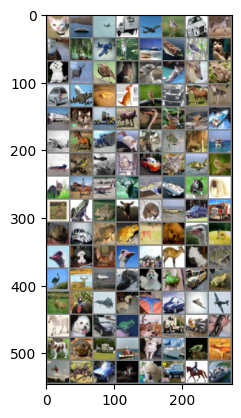

cat   ship  plane truck plane bird  car   horse horse deer  plane deer  ship  ship  bird  cat   dog   deer  bird  horse bird  cat   deer  frog  car   plane frog  cat   bird  car   horse dog   truck cat   truck dog   bird  deer  bird  ship  plane horse truck cat   cat   frog  deer  ship  ship  bird  plane cat   car   cat   plane bird  cat   horse plane deer  plane ship  dog   dog   deer  frog  frog  deer  cat   plane car   truck frog  car   frog  frog  deer  dog   bird  deer  bird  dog   dog   bird  plane deer  cat   frog  bird  deer  plane cat   dog   frog  car   frog  deer  bird  plane dog   plane car   plane plane horse dog   car   frog  deer  truck truck cat   dog   frog  truck ship  dog   ship  frog  deer  plane horse car   horse dog   car   horse ship 


In [4]:
import matplotlib.pyplot as plt
import numpy as np

#Note that the images are normalized and need to be denormalized before being displayed
#The function display_image() is used to display the images using imshow() function from matplotlib


def display_image(img):
    img = img / 2 + 0.5     # for each pixel we applied pixel_value <- (pixel_value - 0.5)/0.5 during normalization, this needs to be reversed
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    #The images are in the format (channel, height, width) and need to be converted to (height, width, channel) for display
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
display_image(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
#We now define the CNN model
#The model consists of 2 convolutional layers and 3 fully connected layers
#The first Conv2D layer converts the input image into 6 channels with a kernel size of 5
#The second Conv2D layer converts the 6 channels into 16 channels with a kernel size of 5
#the MaxPool2D layer reduces the size of the image by a factor of 2 (uses a 2x2 kernel with a stride of 2)

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #32x32x3 -> 28x28x6
        self.pool = nn.MaxPool2d(2, 2) #28x28x6 -> 14x14x6
        self.conv2 = nn.Conv2d(6, 16, 5) #14x14x6 -> 10x10x16
        self.fc1 = nn.Linear(16 * 5 * 5, 120) #10x10x16 -> 5x5x16 (via pooling) which is then fed to the linear layer
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = CNN()

The height and width of the image after a Conv2D are calculated as 
<br>
$$H_{out} = \frac{H_{in}-k+2p}{s} + 1$$
$$W_{out} = \frac{W_{in}-k+2p}{s} + 1$$
Where $k$ is the kernel size, $p$ is the padding and $s$ is the stride.
Our model takes $32 \times 32$ and first converts them to $28 \times 28$ which are compressed to 
<br>
$14 \times 14$ by the action of Maxpool
Finally this is reduced to $10 \times 10$ and $5 \times 5$ by the action of maxpool. We flatten the image before feeding it to the linear layer.

In [10]:
import torch.optim as optim

#We define the loss function and the optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
#The training loop iterates over the dataset over a number of epochs
#We first extract the inputs and labels from the dataset and set the gradients to zero
#We then feed the inputs into the model and calculate the loss using the criterion
#The loss is then backpropagated through the network and the optimizer updates the weights
#The optimizer is then used to update the weights

#Optional: You can print the loss every n iterations to monitor the training progress using running_loss variable

epochs = 10


for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Getting the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Printing
        running_loss += loss.item()
        if i % 100 == 99:    # Print every 100 mini-batches
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0
            
print('Finished Training')


#Write the code to train the model for the specified number of epochs
#The code should display the loss over minibatches and display "Finished Training" after training is complete

[Epoch 1, Batch 100] loss: 2.036
[Epoch 1, Batch 200] loss: 1.722
[Epoch 1, Batch 300] loss: 1.573
[Epoch 2, Batch 100] loss: 1.470
[Epoch 2, Batch 200] loss: 1.422
[Epoch 2, Batch 300] loss: 1.403
[Epoch 3, Batch 100] loss: 1.345
[Epoch 3, Batch 200] loss: 1.307
[Epoch 3, Batch 300] loss: 1.294
[Epoch 4, Batch 100] loss: 1.242
[Epoch 4, Batch 200] loss: 1.239
[Epoch 4, Batch 300] loss: 1.201
[Epoch 5, Batch 100] loss: 1.188
[Epoch 5, Batch 200] loss: 1.178
[Epoch 5, Batch 300] loss: 1.147
[Epoch 6, Batch 100] loss: 1.107
[Epoch 6, Batch 200] loss: 1.124
[Epoch 6, Batch 300] loss: 1.104
[Epoch 7, Batch 100] loss: 1.058
[Epoch 7, Batch 200] loss: 1.060
[Epoch 7, Batch 300] loss: 1.080
[Epoch 8, Batch 100] loss: 1.031
[Epoch 8, Batch 200] loss: 1.021
[Epoch 8, Batch 300] loss: 1.044
[Epoch 9, Batch 100] loss: 0.982
[Epoch 9, Batch 200] loss: 0.980
[Epoch 9, Batch 300] loss: 0.988
[Epoch 10, Batch 100] loss: 0.944
[Epoch 10, Batch 200] loss: 0.963
[Epoch 10, Batch 300] loss: 0.955
Finishe

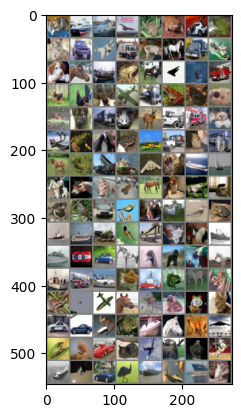

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship  dog   horse ship  frog  horse plane deer  truck dog   bird  deer  plane truck frog  frog  dog   deer  dog   truck bird  deer  car   truck dog   deer  frog  dog   frog  plane truck cat   truck horse frog  truck ship  plane cat   ship  ship  horse horse deer  frog  horse cat   frog  cat   frog  bird  car   bird  cat   horse bird  frog  ship  ship  plane bird  truck cat   cat   ship  ship  car   car   horse bird  dog   bird  horse ship  truck plane cat   ship  frog  deer  frog  frog  plane plane horse deer  dog   frog  cat   car   car   cat   frog  ship  horse deer  plane frog  bird  car   cat   plane deer  bird  horse ship  cat   car   bird  ship  plane ship  cat  


In [12]:
#The model is then tested on the test dataset
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
display_image(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [13]:
correct = 0
total = 0
#We then iterate over the test dataset and calculate the accuracy of the model
#The accuracy is calculated as the number of correct predictions divided by the total number of images
#The model is set to evaluation mode using torch.no_grad() to disable gradient calculation

with torch.no_grad():
    for data in testloader:
        images, labels = data

        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 60 %


In [14]:
#Prepare dictionaries to store the number of correct and total predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

#Using the above code as reference, calculate the accuracy of the model for each class
#The accuracy is calculated as the number of correct predictions divided by the total number of images for each class
#display the accuracy for each class

model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# displaying the accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class {classname}: {accuracy:.2f}%')

Accuracy for class plane: 57.40%
Accuracy for class car: 77.30%
Accuracy for class bird: 32.20%
Accuracy for class cat: 53.60%
Accuracy for class deer: 44.40%
Accuracy for class dog: 54.60%
Accuracy for class frog: 68.50%
Accuracy for class horse: 68.80%
Accuracy for class ship: 80.30%
Accuracy for class truck: 66.60%


<h2>Things to try after completion</h2>
<hr>
<ul>
<li>Experiment with different batch sizes and hyperparameters to maximize model accuracy. You may also choose a different criterion, optimizer.</li>
<li>Experiment with different CNN architectures by modifying the CNN class and its functions. <br>
Use the formula to keep track of input and output layers. Get accuracy for any architechtures you try.</li>
<li>Instead of the CIFAR10, use the MNIST dataset which just has a single channel (B/W) and the images are 28 x 28. <br>
Compare the prediction accuracy of a CNN and a feed-forward linear NN (Try this in a separate notebook)</li>
</ul>